In [503]:
import os
all_files_with_actions = []
for folder in ["preexposure_action", "postcond_action", "postext_action", "postret_action"]:
    all_files_with_actions += os.listdir("/media/data_cifs/anagara8/"+ folder)

In [505]:
# SAVE ALL_FILES_WITH_ACTIONS
np.save("all_frame_and_action_list.npy", all_files_with_actions)

In [506]:
len(all_files_with_actions)

8387210

In [1]:
from datetime import timedelta
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader,random_split
from __future__ import print_function
import numpy as np 
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt 
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
import torchvision.models as models
import pickle
from tqdm.auto import tqdm
import cv2
import wandb
from sklearn.model_selection import KFold
# from torchsummary import summary
import glob
from sklearn.manifold import TSNE
import seaborn as sns
import collections
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import umap.umap_ as UMAP
import pims

/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):
    def __init__(self, z_dim=32):
        super(ResNet18Enc, self).__init__()
        self.z_dim = z_dim
        self.ResNet18 = models.resnet18(pretrained=True)
        self.num_feature = self.ResNet18.fc.in_features
        self.ResNet18.fc = nn.Linear(self.num_feature, 1*self.z_dim)
        
    def forward(self, x):
        x = self.ResNet18(x)
        return x

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=32, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=7)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = F.interpolate(x, size=(112,112), mode='bilinear')
        x = torch.sigmoid(self.conv1(x))
        # [x, channels, height, width]
        x = x.view(x.size(0), 3, 224, 224)
        return x

class newAE(nn.Module):

    def __init__(self, z_dim):
        super(newAE, self).__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
        z = self.encoder(x)
#         mean, logvar = self.encoder(x)
#         z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x

    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

In [3]:
start = time.time()
frame_data_list = np.load("/media/data_cifs/anagara8/OnePercentFramesList.npy")
end = time.time()
print("Training File List containing", len(frame_data_list), "frames loaded in:", end - start)

Training File List containing 8086880 frames loaded in: 40.378238677978516


In [4]:
final_training_list = []

preexposure_count = 0
postcond_count = 0
postext_count = 0
postret_count = 0

# 1353968 -> Number of frames of postret (smallest class)
for sample in frame_data_list:
    if "preexposure" in sample:
        if preexposure_count < 200000:
            final_training_list.append(sample)
            preexposure_count += 1
    elif "postcond" in sample:
        if postcond_count < 200000:
            final_training_list.append(sample)
            postcond_count += 1
    elif "postext" in sample:
        if postext_count < 200000:
            final_training_list.append(sample)
            postext_count += 1
    elif "postret" in sample:
        if postret_count < 200000:
            final_training_list.append(sample)
            postret_count += 1

In [5]:
len(final_training_list)

800000

In [6]:
random.seed(42)
random.shuffle(final_training_list)

In [7]:
final_training_list[0:10]

['/media/data_cifs/anagara8/postcond/FC-B_1-6_postcond_09-21_09-23_2video_2018Y_09M_23D_00h_39m_36s_cam_17202346-0000_156.jpg',
 '/media/data_cifs/anagara8/postret/FC-A_08-15-18_postretvideo_2018Y_08M_20D_10h_03m_29s_cam_17202339-0000_921.jpg',
 '/media/data_cifs/anagara8/postret/FC-C_1-6_postret_10-19_10-video_2018Y_10M_21D_19h_41m_14s_cam_17202345-0000_335.jpg',
 '/media/data_cifs/anagara8/preexposure/FC-D_preexposure_W1_06-01-2019video_2019Y_06M_02D_12h_45m_22s_cam_17202339-0000_724.jpg',
 '/media/data_cifs/anagara8/postcond/FC-D_postcond_W2_06-07-2019_comp2video_2019Y_06M_07D_20h_23m_25s_cam_6394839-0000_623.jpg',
 '/media/data_cifs/anagara8/postret/FC-C_1-6_postret_10-19_10-video_2018Y_10M_19D_12h_41m_05s_cam_17202345-0000_89.jpg',
 '/media/data_cifs/anagara8/postext/FC-D_postext_W3_06-08-2019video_2019Y_06M_08D_20h_08m_23s_cam_6394836-0000_686.jpg',
 '/media/data_cifs/anagara8/preexposure/FC-A_08-07-18_preexposurevideo_2018Y_08M_07D_20h_13m_13s_cam_17202346-0000_568.jpg',
 '/medi

In [8]:
preexposure_count = 0
postcond_count = 0
postext_count = 0
postret_count = 0

preexposure_average = np.zeros((480, 640, 3))
postcond_average = np.zeros((480, 640, 3))
postext_average = np.zeros((480, 640, 3))
postret_average = np.zeros((480, 640, 3))

for sample in final_training_list:
    if "preexposure" in sample:
        if preexposure_count < 1000:
            image = cv2.imread(sample)
            preexposure_average += image/1000
#             cv2.imwrite("/media/data_cifs/anagara8/TrainingViz/preexposure100/frame"+str(preexposure_count)+".jpg", image)
            preexposure_count += 1
    elif "postcond" in sample:
        if postcond_count < 1000:
            image = cv2.imread(sample)
            postcond_average += image/1000
#             cv2.imwrite("/media/data_cifs/anagara8/TrainingViz/postcond100/frame"+str(postcond_count)+".jpg", image)
            postcond_count += 1
    elif "postext" in sample:
        if postext_count < 1000:
            image = cv2.imread(sample)
            postext_average += image/1000
#             cv2.imwrite("/media/data_cifs/anagara8/TrainingViz/postext100/frame"+str(postext_count)+".jpg", image)
            postext_count += 1
    elif "postret" in sample:
        if postret_count < 1000:
            image = cv2.imread(sample)
            postret_average += image/1000
#             cv2.imwrite("/media/data_cifs/anagara8/TrainingViz/postret100/frame"+str(postret_count)+".jpg", image)
            postret_count += 1

### Average Images from Training Set

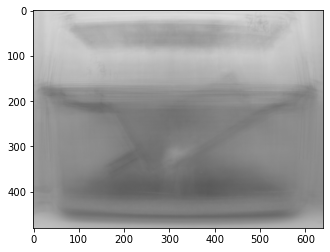

In [9]:
plt.imshow(preexposure_average/255.0, cmap='gray')

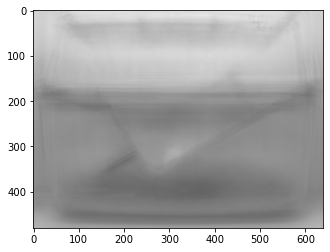

In [10]:
plt.imshow(postcond_average/255.0, cmap='gray')

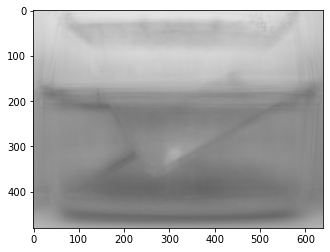

In [11]:
plt.imshow(postext_average/255.0, cmap='gray')

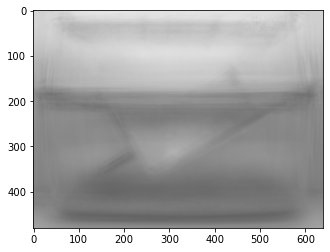

In [12]:
plt.imshow(postret_average/255.0, cmap='gray')

## Disjoint Training Set based on Frames

In [13]:
len(final_training_list)

800000

In [262]:
!ls *.p

before_loss_600.p	      new_architecture_MSE_e1900.p
lights_e0.p		      new_architecture_MSE_e2000.p
Model_new_arch.p	      new_architecture_MSE_e2400.p
Model_new_arch_wLoss.p	      new_architecture_MSE_e800.p
new_architecture_MSE_e1200.p  new_architecture_weighted_loss_e490.p
new_architecture_MSE_e1550.p  old_unnormalized.p
new_architecture_MSE_e1800.p


In [263]:
ae_model_weighted = newAE(32)
ae_model_weighted = nn.DataParallel(ae_model_weighted)
ae_model_weighted = ae_model_weighted.cuda()
ae_model_weighted.load_state_dict(torch.load("new_architecture_MSE_e2400.p"))
ae_model_weighted.eval()

DataParallel(
  (module): newAE(
    (encoder): ResNet18Enc(
      (ResNet18): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [264]:
all_latents_array = []
all_labels_array = []

In [ ]:
image_count = 0

for image in final_training_list[len(all_labels_array):]:
    image_count += 1
    if image_count % 10000 == 0:
        print("Processed", image_count, "Images..")
    name = image
    
    image = cv2.imread(image)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
    tensor_frame = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).cuda()
    with torch.no_grad():
        latent_representation = ae_model_weighted.module.encoder(tensor_frame)
    all_latents_array.append(latent_representation.squeeze().cpu().numpy())
    
    # Append One Hot encoded Labels
    if "preexposure" in name:
        all_labels_array.append([1.0, 0.0, 0.0, 0.0])
    elif "postcond" in name:
        all_labels_array.append([0.0, 1.0, 0.0, 0.0])
    elif "postext" in name:
        all_labels_array.append([0.0, 0.0, 1.0, 0.0])
    elif "postret" in name:
        all_labels_array.append([0.0, 0.0, 0.0, 1.0])
    else:
        print("ERROR: Incorrect Experiment Phase, no label associated.")

        
print("All done!")

In [400]:
len(all_latents_array)

800000

In [403]:
# np.save("800kTrainingLatents_ae_mse.npy", all_latents_array)
# np.save("800kTrainingLabels_ae_mse.npy", all_labels_array)
# np.save("framesUsedFor800kTraining_ae_mse.npy", final_training_list)

# final_training_list = np.load("framesUsedFor800kTraining.npy")
# all_latents_array = np.load("800kTrainingLatents.npy")
# all_labels_array = np.load("800kTrainingLabels.npy")

# final_training_list = np.load("framesUsedFor800kTraining_ae_weighted.npy")
# all_latents_array = np.load("800kTrainingLatents_ae_weighted.npy")
# all_labels_array = np.load("800kTrainingLabels_ae_weighted.npy")

final_training_list = np.load("framesUsedFor800kTraining_ae_mse.npy")
all_latents_array = np.load("800kTrainingLatents_ae_mse.npy")
all_labels_array = np.load("800kTrainingLabels_ae_mse.npy")

In [405]:
# Control animals Experiments:
# final_training_list = np.load("framesUsedFor800kTraining_ae_weighted.npy")
# all_latents_array = np.load("800kTrainingLatents_ae_weighted.npy")
# all_labels_array = np.load("800kTrainingLabels_ae_weighted.npy")

# Control animal camera IDs:
control_animal_list = ["cam_17202338",
                        "cam_17202345",
                        "cam_17202346",#('9')
                        "cam_6394839",
                        "cam_6394846",
                        "cam_6394840"]

control_animal_samples = []
# Store indices for poping
control_animal_indices = []

# Convert from Numpy Array to Python List
final_training_list = final_training_list.tolist()
# Create a copy for sanity checks
final_training_list2 = []

training_latents = []
training_labels = []

testing_latents = []
testing_labels = []

for idx in range(len(final_training_list)):
    # We know all control animals are from FC-D
    animal_found = False
    if "FC-D" in final_training_list[idx]:
        for control_animal in control_animal_list:
            if control_animal in final_training_list[idx]:
                control_animal_samples.append(final_training_list[idx])
                control_animal_indices.append(idx)
                animal_found = True
    if not animal_found:
        training_latents.append(all_latents_array[idx])
        training_labels.append(all_labels_array[idx])
    else:
        testing_latents.append(all_latents_array[idx])
        testing_labels.append(all_labels_array[idx])
            
initial_training_set = set(final_training_list)
control_set = set(control_animal_samples)
final_training_list2 = list(initial_training_set-control_set)

print("Length of untouched Training list:", len(final_training_list))
print("Length of training list without control animals:", len(final_training_list2))
print("Length of control animal list:", len(control_animal_samples))
print("Length of edited training + control animals:", len(control_animal_samples) + len(final_training_list2))
print("Length of corresponding latents and labels:", len(training_latents), len(training_labels))
print("Length of Testing vectors:", len(testing_latents))

Length of untouched Training list: 800000
Length of training list without control animals: 638325
Length of control animal list: 161675
Length of edited training + control animals: 800000
Length of corresponding latents and labels: 638325 638325
Length of Testing vectors: 161675


In [404]:
len(all_labels_array)

800000

In [271]:
preexposure = 0
postcond = 0
postext = 0
postret = 0

for sample in final_training_list2:
    if "preexposure" in sample:
        preexposure += 1
    elif "postcond" in sample:
        postcond += 1
    elif "postext" in sample:
        postext += 1
    elif "postret" in sample:
        postret += 1

print("PCA Training Samples split:\nPreexposure:", preexposure, "\nPostcond:", postcond, "\nPostext:", postext, "\nPostret:", postret)

PCA Training Samples split:
Preexposure: 132739 
Postcond: 167446 
Postext: 160721 
Postret: 177419


In [ ]:
folder_name = files[0].split("video")[0].split("/")[-1]
video_name = "video" + files[0].split("video")[-1].split("-0000_")[-2] + "-0000.csv"
frame_index = files[0].split("0000_")[-1].split(".")[0]
folder_name, video_name, frame_index

In [ ]:
postcond = pd.read_csv(action_data_folder + "/" + folder_name + "/" + video_name, header=None)

In [272]:
# Creating the DataLoader
class LatentDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, augmentations = None):
        super(LatentDataset, self).__init__()
        
        # Latents are stored as the first element
        self.vector_list = [item[0] for item in dataset]
        # Labels are stored as the second element
        self.label_list = [item[1] for item in dataset]
        
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, idx):
        vector = torch.tensor(self.vector_list[idx])
        label = torch.tensor(self.label_list[idx])
        return vector, label

In [23]:
# Processing the Action Classes

action_data_folder = "/media/data_cifs/projects/prj_nih/prj_andrew_holmes/inference/batch_inference/akash/"

preexposure_actions = action_data_folder + "FC-A_08-09-18_preexposure/video_2018Y_08M_09D_19h_18m_24s_cam_17202338-0000.csv"
postcond_actions = action_data_folder + "FC-A_08-10-18_postcond/video_2018Y_08M_13D_19h_21m_04s_cam_17202338-0000.csv"
postext_actions = action_data_folder + "FC-A_08-15-18_postext/video_2018Y_08M_15D_18h_58m_45s_cam_17202338-0000.csv"
postret_actions = action_data_folder + "FC-A_08-15-18_postret/video_2018Y_08M_17D_19h_03m_18s_cam_17202338-0000.csv"

preexposure_actions = pd.read_csv(preexposure_actions, header=None)
postcond_actions = pd.read_csv(postcond_actions, header=None)
postext_actions = pd.read_csv(postext_actions, header=None)
postret_actions = pd.read_csv(postret_actions, header=None)

In [24]:
folder_name = final_training_list[0].split("video")[0].split("/")[-1]
video_name = "video" + final_training_list[0].split("video")[-1].split("-0000_")[-2] + "-0000.csv"
folder_name, video_name

('FC-B_1-6_postcond_09-21_09-23_2',
 'video_2018Y_09M_23D_00h_39m_36s_cam_17202346-0000.csv')

In [406]:
m = len(training_labels)
test_train_split = 0.2

torch.manual_seed(42)

train_data, val_data = random_split(list(zip(training_latents, training_labels)), [int(math.ceil(m-m*test_train_split)), int(m*test_train_split)])
print("Length:", len(train_data) + len(val_data), "-> Training set size:", len(train_data), "| Validation set size:", len(val_data))

# train_data, val_data = random_split(list(zip(all_latents_array, all_labels_array)), [int(math.ceil(m-m*test_train_split)), int(m*test_train_split)])
# print("Length:", len(train_data) + len(val_data), "-> Training set size:", len(train_data), "| Validation set size:", len(val_data))

Length: 638325 -> Training set size: 510660 | Validation set size: 127665


In [407]:
class NotReproducibleError(Exception):
    """Base class for other exceptions"""
    pass

def get_experiment_phase_from_name(file_name):
    if "preexposure" in file_name:
        return [1.0, 0.0, 0.0, 0.0]
    elif "postcond" in file_name:
        return [0.0, 1.0, 0.0, 0.0]
    elif "postext" in file_name:
        return [0.0, 0.0, 1.0, 0.0]
    elif "postret" in file_name:
        return [0.0, 0.0, 0.0, 1.0]
    else:
        raise NotReproducibleError

In [408]:
len(train_data)

510660

In [ ]:
# Ensuring reproducibility of the dataset
torch.manual_seed(42)
# train_frame_names, val_frame_names = random_split(final_training_list, [int(math.ceil(m-m*test_train_split)), int(m*test_train_split)])
train_frame_names, val_frame_names = random_split(final_training_list2, [int(math.ceil(m-m*test_train_split)), int(m*test_train_split)])

for i in range(len(train_frame_names)):
    if get_experiment_phase_from_name(train_frame_names[i]) != train_data[i][1]:
        raise NotReproducibleError

for i in range(len(val_frame_names)):
    if get_experiment_phase_from_name(val_frame_names[i]) != val_data[i][1]:
        raise NotReproducibleError

In [409]:
train_dataset = LatentDataset(train_data)
val_dataset = LatentDataset(val_data)

In [410]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers = 4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers = 4, shuffle=False)

In [411]:
# Ensuring shuffling by printing the first 6 samples
for i in range(6):
    print(train_loader.dataset[i])

(tensor([ 0.3428, -0.2076,  0.3324,  0.9764,  0.7692,  0.8998, -0.3560, -0.5751,
        -0.5972,  0.8268, -0.2625, -0.3528,  0.3090, -0.4744,  0.0620,  0.2573,
         0.8760,  0.3243, -0.2564,  0.1605,  0.1661,  0.8547, -0.3663,  1.5286,
        -0.9543, -0.3689, -0.6496, -0.5108, -0.5864, -0.0694, -0.0921,  0.3921]), tensor([0., 0., 0., 1.], dtype=torch.float64))
(tensor([-0.1530,  0.1166, -0.6178,  0.3668,  0.6301, -0.2644,  0.1747,  0.0162,
         0.3426,  0.2690, -0.5883, -0.2161, -0.2267,  0.8721, -1.1197,  0.1585,
        -0.6383,  0.6939, -0.3768, -0.2747, -0.4912, -0.4533, -0.3500, -0.3440,
        -0.4425,  0.2185, -0.2332,  0.0899,  0.4734,  0.9023,  0.7854,  0.3469]), tensor([1., 0., 0., 0.], dtype=torch.float64))
(tensor([ 0.5078, -0.2479, -0.0342, -0.4497, -0.1571,  0.7459,  0.1853, -0.2814,
         0.0388,  1.0600,  0.7733, -0.4461, -0.4148, -0.4531,  0.4860, -0.1203,
         0.3355,  0.2938,  0.1367,  0.3119,  0.0569, -0.6398,  1.2347,  0.2288,
        -0.7323, -0

In [412]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 128)
        self.hidden_fc1 = nn.Linear(128, 64)
        self.hidden_fc2 = nn.Linear(64, 32)
        self.output_fc = nn.Linear(32, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc1(h_1))
        h_3 = F.relu(self.hidden_fc2(h_2))
        y_out = self.output_fc(h_3)
        y_pred = torch.sigmoid(y_out)
        
        return y_out

In [413]:
INPUT_DIM = 32
OUTPUT_DIM = 4

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [414]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", device)

Using cuda


In [415]:
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.000001)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [416]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [417]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def calculate_accuracy(y_pred, y):
    y_pred = torch.argmax(y_pred, dim = 1)
    y = torch.argmax(y, dim = 1)
    
    acc = torch.unique(y_pred[y_pred==y], return_counts = True)[1].sum()
    acc = acc / y.shape[0]
    return acc

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,692 trainable parameters


In [418]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for sample in tqdm(iterator, desc="Validating", leave=False):
            latent, label = sample
        
            latent = latent.to(device)
            label = label.squeeze().to(device)
            
            y_pred = model(latent)

            loss = criterion(y_pred, label)
            acc = calculate_accuracy(y_pred, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [419]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for sample in tqdm(iterator, desc="Training", leave=False):
        latent, label = sample
        
        latent = latent.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        y_pred = model(latent)

        loss = criterion(y_pred, label)
        acc = calculate_accuracy(y_pred, label)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [293]:
random.seed(1234)
testing_sample_number = 1200000
test_list = []#random.sample(training_data_list, testing_sample_number)

test_sample_count = 1
for i in range(len(frame_data_list)):
    if test_sample_count > testing_sample_number:
        break
    if frame_data_list[i] not in final_training_list:
        test_list.append(frame_data_list[i])
        test_sample_count += 1
    if test_sample_count % 10000 == 0:
        print("Processed", test_sample_count, "samples..")
#     else:
#         print(frame_data_list[i], "occurs in the Training list, so it is excluded from the training list.")

KeyboardInterrupt: 

In [172]:
len(final_training_list2)

638325

In [288]:
EPOCHS = 250
best_valid_loss = float('inf')
list_train_loss = []
list_val_loss = []

list_train_acc = []
list_val_acc = []

for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, device)
    
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.7f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.7f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    list_val_loss.append(valid_loss)
    list_train_loss.append(train_loss)
    
    list_val_acc.append(valid_acc)
    list_train_acc.append(train_acc)
    
    if (epoch %20 == 0 or (epoch > 200 and epoch %5 == 0))and valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "./LinearClassifierFinal/control_animals_expt_mse_e"+str(epoch)+"_v"+str(valid_acc)+".p")
print('Finished Training')

Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 1.3986822 | Train Acc: 20.79%
	 Val. Loss: 1.3952351 |  Val. Acc: 20.83%


Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 1.3917273 | Train Acc: 20.79%
	 Val. Loss: 1.3883116 |  Val. Acc: 20.86%


Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 1.3847469 | Train Acc: 22.56%
	 Val. Loss: 1.3812695 |  Val. Acc: 25.85%


Epoch: 04 | Epoch Time: 0m 17s
	Train Loss: 1.3775698 | Train Acc: 28.76%
	 Val. Loss: 1.3740143 |  Val. Acc: 31.63%


Epoch: 05 | Epoch Time: 0m 17s
	Train Loss: 1.3700955 | Train Acc: 33.70%
	 Val. Loss: 1.3663213 |  Val. Acc: 35.05%


Epoch: 06 | Epoch Time: 0m 16s
	Train Loss: 1.3620009 | Train Acc: 37.18%
	 Val. Loss: 1.3579658 |  Val. Acc: 39.55%


Epoch: 07 | Epoch Time: 0m 17s
	Train Loss: 1.3533332 | Train Acc: 40.47%
	 Val. Loss: 1.3491101 |  Val. Acc: 40.17%


Epoch: 08 | Epoch Time: 0m 17s
	Train Loss: 1.3441686 | Train Acc: 40.17%
	 Val. Loss: 1.3397732 |  Val. Acc: 39.89%


Epoch: 09 | Epoch Time: 0m 16s
	Train Loss: 1.3345455 | Train Acc: 39.99%
	 Val. Loss: 1.3299765 |  Val. Acc: 39.69%


Epoch: 10 | Epoch Time: 0m 17s
	Train Loss: 1.3244249 | Train Acc: 39.82%
	 Val. Loss: 1.3197022 |  Val. Acc: 39.66%


Epoch: 11 | Epoch Time: 0m 17s
	Train Loss: 1.3138786 | Train Acc: 39.87%
	 Val. Loss: 1.3090597 |  Val. Acc: 39.83%


Epoch: 12 | Epoch Time: 0m 16s
	Train Loss: 1.3029872 | Train Acc: 40.12%
	 Val. Loss: 1.2981039 |  Val. Acc: 40.15%


Epoch: 13 | Epoch Time: 0m 16s
	Train Loss: 1.2918452 | Train Acc: 40.41%
	 Val. Loss: 1.2869452 |  Val. Acc: 40.45%


Epoch: 14 | Epoch Time: 0m 16s
	Train Loss: 1.2805142 | Train Acc: 40.74%
	 Val. Loss: 1.2755792 |  Val. Acc: 40.80%


Epoch: 15 | Epoch Time: 0m 16s
	Train Loss: 1.2689973 | Train Acc: 41.13%
	 Val. Loss: 1.2640484 |  Val. Acc: 41.21%


Epoch: 16 | Epoch Time: 0m 17s
	Train Loss: 1.2573694 | Train Acc: 41.59%
	 Val. Loss: 1.2524194 |  Val. Acc: 41.71%


Epoch: 17 | Epoch Time: 0m 16s
	Train Loss: 1.2456290 | Train Acc: 42.00%
	 Val. Loss: 1.2406572 |  Val. Acc: 42.09%


Epoch: 18 | Epoch Time: 0m 17s
	Train Loss: 1.2337968 | Train Acc: 42.33%
	 Val. Loss: 1.2288049 |  Val. Acc: 42.47%


Epoch: 19 | Epoch Time: 0m 17s
	Train Loss: 1.2218777 | Train Acc: 42.72%
	 Val. Loss: 1.2168734 |  Val. Acc: 42.83%


Epoch: 20 | Epoch Time: 0m 16s
	Train Loss: 1.2099116 | Train Acc: 43.11%
	 Val. Loss: 1.2049143 |  Val. Acc: 43.20%


Epoch: 21 | Epoch Time: 0m 16s
	Train Loss: 1.1979843 | Train Acc: 43.47%
	 Val. Loss: 1.1929827 |  Val. Acc: 43.57%


Epoch: 22 | Epoch Time: 0m 16s
	Train Loss: 1.1860431 | Train Acc: 43.93%
	 Val. Loss: 1.1810267 |  Val. Acc: 44.04%


Epoch: 23 | Epoch Time: 0m 16s
	Train Loss: 1.1740942 | Train Acc: 44.45%
	 Val. Loss: 1.1690299 |  Val. Acc: 44.66%


Epoch: 24 | Epoch Time: 0m 17s
	Train Loss: 1.1621580 | Train Acc: 45.23%
	 Val. Loss: 1.1571256 |  Val. Acc: 45.44%


Epoch: 25 | Epoch Time: 0m 16s
	Train Loss: 1.1503216 | Train Acc: 45.99%
	 Val. Loss: 1.1452948 |  Val. Acc: 46.13%


Epoch: 26 | Epoch Time: 0m 16s
	Train Loss: 1.1385998 | Train Acc: 46.62%
	 Val. Loss: 1.1335718 |  Val. Acc: 46.64%


Epoch: 27 | Epoch Time: 0m 17s
	Train Loss: 1.1269946 | Train Acc: 47.17%
	 Val. Loss: 1.1220063 |  Val. Acc: 47.28%


Epoch: 28 | Epoch Time: 0m 16s
	Train Loss: 1.1155513 | Train Acc: 47.80%
	 Val. Loss: 1.1105914 |  Val. Acc: 47.96%


Epoch: 29 | Epoch Time: 0m 17s
	Train Loss: 1.1042740 | Train Acc: 48.53%
	 Val. Loss: 1.0993336 |  Val. Acc: 48.73%


Epoch: 30 | Epoch Time: 0m 17s
	Train Loss: 1.0931535 | Train Acc: 49.18%
	 Val. Loss: 1.0882478 |  Val. Acc: 49.36%


Epoch: 31 | Epoch Time: 0m 16s
	Train Loss: 1.0822084 | Train Acc: 49.80%
	 Val. Loss: 1.0773417 |  Val. Acc: 50.06%


Epoch: 32 | Epoch Time: 0m 17s
	Train Loss: 1.0714520 | Train Acc: 50.50%
	 Val. Loss: 1.0666431 |  Val. Acc: 50.76%


Epoch: 33 | Epoch Time: 0m 17s
	Train Loss: 1.0609239 | Train Acc: 51.26%
	 Val. Loss: 1.0561669 |  Val. Acc: 51.42%


Epoch: 34 | Epoch Time: 0m 17s
	Train Loss: 1.0505553 | Train Acc: 51.85%
	 Val. Loss: 1.0458195 |  Val. Acc: 52.03%


Epoch: 35 | Epoch Time: 0m 17s
	Train Loss: 1.0403402 | Train Acc: 52.44%
	 Val. Loss: 1.0356283 |  Val. Acc: 52.61%


Epoch: 36 | Epoch Time: 0m 17s
	Train Loss: 1.0302635 | Train Acc: 53.02%
	 Val. Loss: 1.0255855 |  Val. Acc: 53.11%


Epoch: 37 | Epoch Time: 0m 16s
	Train Loss: 1.0203385 | Train Acc: 53.63%
	 Val. Loss: 1.0156789 |  Val. Acc: 53.73%


Epoch: 38 | Epoch Time: 0m 16s
	Train Loss: 1.0105593 | Train Acc: 54.29%
	 Val. Loss: 1.0059122 |  Val. Acc: 54.37%


Epoch: 39 | Epoch Time: 0m 16s
	Train Loss: 1.0009404 | Train Acc: 54.90%
	 Val. Loss: 0.9963484 |  Val. Acc: 55.03%


Epoch: 40 | Epoch Time: 0m 17s
	Train Loss: 0.9915197 | Train Acc: 55.58%
	 Val. Loss: 0.9869666 |  Val. Acc: 55.74%


Epoch: 41 | Epoch Time: 0m 16s
	Train Loss: 0.9822670 | Train Acc: 56.27%
	 Val. Loss: 0.9777653 |  Val. Acc: 56.41%


Epoch: 42 | Epoch Time: 0m 15s
	Train Loss: 0.9731928 | Train Acc: 56.94%
	 Val. Loss: 0.9687030 |  Val. Acc: 57.05%


Epoch: 43 | Epoch Time: 0m 15s
	Train Loss: 0.9642519 | Train Acc: 57.53%
	 Val. Loss: 0.9597817 |  Val. Acc: 57.71%


Epoch: 44 | Epoch Time: 0m 16s
	Train Loss: 0.9554462 | Train Acc: 58.13%
	 Val. Loss: 0.9510017 |  Val. Acc: 58.25%


Epoch: 45 | Epoch Time: 0m 15s
	Train Loss: 0.9467647 | Train Acc: 58.65%
	 Val. Loss: 0.9423631 |  Val. Acc: 58.74%


Epoch: 46 | Epoch Time: 0m 16s
	Train Loss: 0.9382554 | Train Acc: 59.11%
	 Val. Loss: 0.9339220 |  Val. Acc: 59.21%


Epoch: 47 | Epoch Time: 0m 16s
	Train Loss: 0.9299264 | Train Acc: 59.64%
	 Val. Loss: 0.9256451 |  Val. Acc: 59.75%


Epoch: 48 | Epoch Time: 0m 17s
	Train Loss: 0.9217725 | Train Acc: 60.16%
	 Val. Loss: 0.9175250 |  Val. Acc: 60.32%


Epoch: 49 | Epoch Time: 0m 16s
	Train Loss: 0.9138022 | Train Acc: 60.68%
	 Val. Loss: 0.9096205 |  Val. Acc: 60.80%


Epoch: 50 | Epoch Time: 0m 16s
	Train Loss: 0.9059771 | Train Acc: 61.18%
	 Val. Loss: 0.9018256 |  Val. Acc: 61.31%


Epoch: 51 | Epoch Time: 0m 17s
	Train Loss: 0.8983032 | Train Acc: 61.66%
	 Val. Loss: 0.8942049 |  Val. Acc: 61.86%


Epoch: 52 | Epoch Time: 0m 15s
	Train Loss: 0.8907879 | Train Acc: 62.16%
	 Val. Loss: 0.8867223 |  Val. Acc: 62.30%


Epoch: 53 | Epoch Time: 0m 16s
	Train Loss: 0.8834042 | Train Acc: 62.59%
	 Val. Loss: 0.8793959 |  Val. Acc: 62.75%


Epoch: 54 | Epoch Time: 0m 17s
	Train Loss: 0.8761644 | Train Acc: 63.05%
	 Val. Loss: 0.8721900 |  Val. Acc: 63.18%


Epoch: 55 | Epoch Time: 0m 16s
	Train Loss: 0.8690585 | Train Acc: 63.48%
	 Val. Loss: 0.8651186 |  Val. Acc: 63.65%


Epoch: 56 | Epoch Time: 0m 16s
	Train Loss: 0.8620679 | Train Acc: 63.90%
	 Val. Loss: 0.8581793 |  Val. Acc: 64.07%


Epoch: 57 | Epoch Time: 0m 16s
	Train Loss: 0.8552102 | Train Acc: 64.32%
	 Val. Loss: 0.8513456 |  Val. Acc: 64.51%


Epoch: 58 | Epoch Time: 0m 16s
	Train Loss: 0.8484237 | Train Acc: 64.74%
	 Val. Loss: 0.8445843 |  Val. Acc: 64.88%


Epoch: 59 | Epoch Time: 0m 16s
	Train Loss: 0.8417538 | Train Acc: 65.13%
	 Val. Loss: 0.8379421 |  Val. Acc: 65.27%


Epoch: 60 | Epoch Time: 0m 16s
	Train Loss: 0.8351698 | Train Acc: 65.50%
	 Val. Loss: 0.8313807 |  Val. Acc: 65.61%


Epoch: 61 | Epoch Time: 0m 16s
	Train Loss: 0.8286940 | Train Acc: 65.83%
	 Val. Loss: 0.8249490 |  Val. Acc: 66.00%


Epoch: 62 | Epoch Time: 0m 15s
	Train Loss: 0.8223260 | Train Acc: 66.16%
	 Val. Loss: 0.8186041 |  Val. Acc: 66.32%


Epoch: 63 | Epoch Time: 0m 16s
	Train Loss: 0.8160290 | Train Acc: 66.46%
	 Val. Loss: 0.8123092 |  Val. Acc: 66.62%


Epoch: 64 | Epoch Time: 0m 17s
	Train Loss: 0.8097713 | Train Acc: 66.77%
	 Val. Loss: 0.8060607 |  Val. Acc: 66.94%


Epoch: 65 | Epoch Time: 0m 16s
	Train Loss: 0.8035840 | Train Acc: 67.08%
	 Val. Loss: 0.7998917 |  Val. Acc: 67.29%


Epoch: 66 | Epoch Time: 0m 17s
	Train Loss: 0.7974757 | Train Acc: 67.41%
	 Val. Loss: 0.7937978 |  Val. Acc: 67.58%


Epoch: 67 | Epoch Time: 0m 16s
	Train Loss: 0.7914064 | Train Acc: 67.71%
	 Val. Loss: 0.7877268 |  Val. Acc: 67.89%


Epoch: 68 | Epoch Time: 0m 17s
	Train Loss: 0.7853688 | Train Acc: 68.02%
	 Val. Loss: 0.7816913 |  Val. Acc: 68.25%


Epoch: 69 | Epoch Time: 0m 17s
	Train Loss: 0.7793659 | Train Acc: 68.35%
	 Val. Loss: 0.7757056 |  Val. Acc: 68.54%


Epoch: 70 | Epoch Time: 0m 17s
	Train Loss: 0.7734266 | Train Acc: 68.66%
	 Val. Loss: 0.7697776 |  Val. Acc: 68.88%


Epoch: 71 | Epoch Time: 0m 17s
	Train Loss: 0.7675082 | Train Acc: 69.04%
	 Val. Loss: 0.7638552 |  Val. Acc: 69.17%


Epoch: 72 | Epoch Time: 0m 16s
	Train Loss: 0.7616225 | Train Acc: 69.33%
	 Val. Loss: 0.7579644 |  Val. Acc: 69.57%


Epoch: 73 | Epoch Time: 0m 16s
	Train Loss: 0.7557453 | Train Acc: 69.68%
	 Val. Loss: 0.7520833 |  Val. Acc: 69.85%


Epoch: 74 | Epoch Time: 0m 17s
	Train Loss: 0.7498986 | Train Acc: 69.99%
	 Val. Loss: 0.7462920 |  Val. Acc: 70.23%


Epoch: 75 | Epoch Time: 0m 16s
	Train Loss: 0.7441153 | Train Acc: 70.31%
	 Val. Loss: 0.7404899 |  Val. Acc: 70.56%


Epoch: 76 | Epoch Time: 0m 17s
	Train Loss: 0.7383212 | Train Acc: 70.61%
	 Val. Loss: 0.7347029 |  Val. Acc: 70.84%


Epoch: 77 | Epoch Time: 0m 16s
	Train Loss: 0.7325464 | Train Acc: 70.91%
	 Val. Loss: 0.7289211 |  Val. Acc: 71.11%


Epoch: 78 | Epoch Time: 0m 17s
	Train Loss: 0.7267780 | Train Acc: 71.21%
	 Val. Loss: 0.7231683 |  Val. Acc: 71.38%


Epoch: 79 | Epoch Time: 0m 17s
	Train Loss: 0.7210451 | Train Acc: 71.48%
	 Val. Loss: 0.7174569 |  Val. Acc: 71.77%


Epoch: 80 | Epoch Time: 0m 17s
	Train Loss: 0.7153291 | Train Acc: 71.78%
	 Val. Loss: 0.7117426 |  Val. Acc: 72.09%


Epoch: 81 | Epoch Time: 0m 17s
	Train Loss: 0.7096127 | Train Acc: 72.13%
	 Val. Loss: 0.7060494 |  Val. Acc: 72.25%


Epoch: 82 | Epoch Time: 0m 15s
	Train Loss: 0.7039444 | Train Acc: 72.38%
	 Val. Loss: 0.7004185 |  Val. Acc: 72.69%


Epoch: 83 | Epoch Time: 0m 15s
	Train Loss: 0.6982781 | Train Acc: 72.71%
	 Val. Loss: 0.6947423 |  Val. Acc: 72.93%


Epoch: 84 | Epoch Time: 0m 17s
	Train Loss: 0.6926544 | Train Acc: 73.01%
	 Val. Loss: 0.6891222 |  Val. Acc: 73.23%


Epoch: 85 | Epoch Time: 0m 16s
	Train Loss: 0.6870219 | Train Acc: 73.33%
	 Val. Loss: 0.6835100 |  Val. Acc: 73.58%


Epoch: 86 | Epoch Time: 0m 17s
	Train Loss: 0.6814266 | Train Acc: 73.65%
	 Val. Loss: 0.6779333 |  Val. Acc: 73.89%


Epoch: 87 | Epoch Time: 0m 17s
	Train Loss: 0.6758290 | Train Acc: 73.96%
	 Val. Loss: 0.6723817 |  Val. Acc: 74.17%


Epoch: 88 | Epoch Time: 0m 16s
	Train Loss: 0.6702859 | Train Acc: 74.26%
	 Val. Loss: 0.6668563 |  Val. Acc: 74.49%


Epoch: 89 | Epoch Time: 0m 16s
	Train Loss: 0.6647410 | Train Acc: 74.59%
	 Val. Loss: 0.6613220 |  Val. Acc: 74.80%


Epoch: 90 | Epoch Time: 0m 16s
	Train Loss: 0.6592101 | Train Acc: 74.88%
	 Val. Loss: 0.6558133 |  Val. Acc: 75.12%


Epoch: 91 | Epoch Time: 0m 17s
	Train Loss: 0.6536884 | Train Acc: 75.16%
	 Val. Loss: 0.6503103 |  Val. Acc: 75.44%


Epoch: 92 | Epoch Time: 0m 17s
	Train Loss: 0.6481734 | Train Acc: 75.44%
	 Val. Loss: 0.6448324 |  Val. Acc: 75.74%


Epoch: 93 | Epoch Time: 0m 16s
	Train Loss: 0.6426772 | Train Acc: 75.73%
	 Val. Loss: 0.6393560 |  Val. Acc: 75.97%


Epoch: 94 | Epoch Time: 0m 17s
	Train Loss: 0.6371946 | Train Acc: 75.99%
	 Val. Loss: 0.6338790 |  Val. Acc: 76.22%


Epoch: 95 | Epoch Time: 0m 16s
	Train Loss: 0.6317095 | Train Acc: 76.24%
	 Val. Loss: 0.6284151 |  Val. Acc: 76.44%


Epoch: 96 | Epoch Time: 0m 16s
	Train Loss: 0.6262262 | Train Acc: 76.53%
	 Val. Loss: 0.6229689 |  Val. Acc: 76.68%


Epoch: 97 | Epoch Time: 0m 16s
	Train Loss: 0.6207735 | Train Acc: 76.77%
	 Val. Loss: 0.6175519 |  Val. Acc: 76.97%


Epoch: 98 | Epoch Time: 0m 17s
	Train Loss: 0.6153246 | Train Acc: 77.01%
	 Val. Loss: 0.6121081 |  Val. Acc: 77.27%


Epoch: 99 | Epoch Time: 0m 16s
	Train Loss: 0.6098766 | Train Acc: 77.28%
	 Val. Loss: 0.6066875 |  Val. Acc: 77.55%


Epoch: 100 | Epoch Time: 0m 17s
	Train Loss: 0.6044359 | Train Acc: 77.56%
	 Val. Loss: 0.6012510 |  Val. Acc: 77.75%


Epoch: 101 | Epoch Time: 0m 17s
	Train Loss: 0.5989967 | Train Acc: 77.82%
	 Val. Loss: 0.5958431 |  Val. Acc: 78.04%


Epoch: 102 | Epoch Time: 0m 16s
	Train Loss: 0.5935596 | Train Acc: 78.11%
	 Val. Loss: 0.5904214 |  Val. Acc: 78.31%


Epoch: 103 | Epoch Time: 0m 15s
	Train Loss: 0.5880789 | Train Acc: 78.40%
	 Val. Loss: 0.5849316 |  Val. Acc: 78.59%


Epoch: 104 | Epoch Time: 0m 16s
	Train Loss: 0.5825989 | Train Acc: 78.70%
	 Val. Loss: 0.5794883 |  Val. Acc: 78.88%


Epoch: 105 | Epoch Time: 0m 17s
	Train Loss: 0.5771351 | Train Acc: 78.98%
	 Val. Loss: 0.5740361 |  Val. Acc: 79.17%


Epoch: 106 | Epoch Time: 0m 17s
	Train Loss: 0.5716699 | Train Acc: 79.26%
	 Val. Loss: 0.5686126 |  Val. Acc: 79.39%


Epoch: 107 | Epoch Time: 0m 17s
	Train Loss: 0.5662255 | Train Acc: 79.50%
	 Val. Loss: 0.5631792 |  Val. Acc: 79.64%


Epoch: 108 | Epoch Time: 0m 17s
	Train Loss: 0.5607845 | Train Acc: 79.75%
	 Val. Loss: 0.5577713 |  Val. Acc: 79.88%


Epoch: 109 | Epoch Time: 0m 17s
	Train Loss: 0.5553418 | Train Acc: 79.99%
	 Val. Loss: 0.5523500 |  Val. Acc: 80.14%


Epoch: 110 | Epoch Time: 0m 17s
	Train Loss: 0.5499212 | Train Acc: 80.22%
	 Val. Loss: 0.5469656 |  Val. Acc: 80.37%


Epoch: 111 | Epoch Time: 0m 16s
	Train Loss: 0.5445078 | Train Acc: 80.43%
	 Val. Loss: 0.5415573 |  Val. Acc: 80.63%


Epoch: 112 | Epoch Time: 0m 16s
	Train Loss: 0.5390774 | Train Acc: 80.68%
	 Val. Loss: 0.5361496 |  Val. Acc: 80.85%


Epoch: 113 | Epoch Time: 0m 17s
	Train Loss: 0.5336625 | Train Acc: 80.91%
	 Val. Loss: 0.5307558 |  Val. Acc: 81.07%


Epoch: 114 | Epoch Time: 0m 17s
	Train Loss: 0.5282505 | Train Acc: 81.14%
	 Val. Loss: 0.5253751 |  Val. Acc: 81.32%


Epoch: 115 | Epoch Time: 0m 17s
	Train Loss: 0.5228501 | Train Acc: 81.39%
	 Val. Loss: 0.5199962 |  Val. Acc: 81.53%


Epoch: 116 | Epoch Time: 0m 16s
	Train Loss: 0.5174668 | Train Acc: 81.61%
	 Val. Loss: 0.5146468 |  Val. Acc: 81.78%


Epoch: 117 | Epoch Time: 0m 17s
	Train Loss: 0.5120792 | Train Acc: 81.86%
	 Val. Loss: 0.5092791 |  Val. Acc: 82.07%


Epoch: 118 | Epoch Time: 0m 17s
	Train Loss: 0.5067016 | Train Acc: 82.13%
	 Val. Loss: 0.5039107 |  Val. Acc: 82.31%


Epoch: 119 | Epoch Time: 0m 17s
	Train Loss: 0.5013303 | Train Acc: 82.40%
	 Val. Loss: 0.4985529 |  Val. Acc: 82.53%


Epoch: 120 | Epoch Time: 0m 17s
	Train Loss: 0.4959757 | Train Acc: 82.63%
	 Val. Loss: 0.4932315 |  Val. Acc: 82.79%


Epoch: 121 | Epoch Time: 0m 17s
	Train Loss: 0.4906311 | Train Acc: 82.87%
	 Val. Loss: 0.4879225 |  Val. Acc: 83.09%


Epoch: 122 | Epoch Time: 0m 15s
	Train Loss: 0.4852920 | Train Acc: 83.12%
	 Val. Loss: 0.4825735 |  Val. Acc: 83.33%


Epoch: 123 | Epoch Time: 0m 16s
	Train Loss: 0.4799347 | Train Acc: 83.34%
	 Val. Loss: 0.4772466 |  Val. Acc: 83.57%


Epoch: 124 | Epoch Time: 0m 17s
	Train Loss: 0.4746029 | Train Acc: 83.59%
	 Val. Loss: 0.4719269 |  Val. Acc: 83.77%


Epoch: 125 | Epoch Time: 0m 16s
	Train Loss: 0.4692679 | Train Acc: 83.84%
	 Val. Loss: 0.4665917 |  Val. Acc: 84.03%


Epoch: 126 | Epoch Time: 0m 16s
	Train Loss: 0.4639327 | Train Acc: 84.07%
	 Val. Loss: 0.4612806 |  Val. Acc: 84.28%


Epoch: 127 | Epoch Time: 0m 17s
	Train Loss: 0.4586180 | Train Acc: 84.33%
	 Val. Loss: 0.4559761 |  Val. Acc: 84.53%


Epoch: 128 | Epoch Time: 0m 16s
	Train Loss: 0.4533278 | Train Acc: 84.57%
	 Val. Loss: 0.4507177 |  Val. Acc: 84.80%


Epoch: 129 | Epoch Time: 0m 17s
	Train Loss: 0.4480334 | Train Acc: 84.83%
	 Val. Loss: 0.4454204 |  Val. Acc: 85.03%


Epoch: 130 | Epoch Time: 0m 16s
	Train Loss: 0.4427210 | Train Acc: 85.07%
	 Val. Loss: 0.4401006 |  Val. Acc: 85.26%


Epoch: 131 | Epoch Time: 0m 16s
	Train Loss: 0.4373975 | Train Acc: 85.32%
	 Val. Loss: 0.4348205 |  Val. Acc: 85.52%


Epoch: 132 | Epoch Time: 0m 16s
	Train Loss: 0.4321051 | Train Acc: 85.56%
	 Val. Loss: 0.4295354 |  Val. Acc: 85.75%


Epoch: 133 | Epoch Time: 0m 16s
	Train Loss: 0.4268193 | Train Acc: 85.80%
	 Val. Loss: 0.4242424 |  Val. Acc: 85.97%


Epoch: 134 | Epoch Time: 0m 16s
	Train Loss: 0.4215144 | Train Acc: 86.06%
	 Val. Loss: 0.4189574 |  Val. Acc: 86.23%


Epoch: 135 | Epoch Time: 0m 17s
	Train Loss: 0.4162035 | Train Acc: 86.34%
	 Val. Loss: 0.4136581 |  Val. Acc: 86.54%


Epoch: 136 | Epoch Time: 0m 17s
	Train Loss: 0.4108833 | Train Acc: 86.63%
	 Val. Loss: 0.4083472 |  Val. Acc: 86.77%


Epoch: 137 | Epoch Time: 0m 16s
	Train Loss: 0.4055431 | Train Acc: 86.91%
	 Val. Loss: 0.4030201 |  Val. Acc: 87.03%


Epoch: 138 | Epoch Time: 0m 17s
	Train Loss: 0.4001984 | Train Acc: 87.16%
	 Val. Loss: 0.3976801 |  Val. Acc: 87.28%


Epoch: 139 | Epoch Time: 0m 16s
	Train Loss: 0.3948762 | Train Acc: 87.41%
	 Val. Loss: 0.3924062 |  Val. Acc: 87.52%


Epoch: 140 | Epoch Time: 0m 16s
	Train Loss: 0.3895901 | Train Acc: 87.65%
	 Val. Loss: 0.3871562 |  Val. Acc: 87.78%


Epoch: 141 | Epoch Time: 0m 16s
	Train Loss: 0.3843352 | Train Acc: 87.90%
	 Val. Loss: 0.3819638 |  Val. Acc: 88.05%


Epoch: 142 | Epoch Time: 0m 16s
	Train Loss: 0.3791190 | Train Acc: 88.17%
	 Val. Loss: 0.3767779 |  Val. Acc: 88.30%


Epoch: 143 | Epoch Time: 0m 16s
	Train Loss: 0.3739755 | Train Acc: 88.46%
	 Val. Loss: 0.3716365 |  Val. Acc: 88.52%


Epoch: 144 | Epoch Time: 0m 16s
	Train Loss: 0.3688422 | Train Acc: 88.73%
	 Val. Loss: 0.3665354 |  Val. Acc: 88.79%


Epoch: 145 | Epoch Time: 0m 16s
	Train Loss: 0.3637364 | Train Acc: 88.99%
	 Val. Loss: 0.3614474 |  Val. Acc: 89.07%


Epoch: 146 | Epoch Time: 0m 17s
	Train Loss: 0.3586556 | Train Acc: 89.23%
	 Val. Loss: 0.3564029 |  Val. Acc: 89.30%


Epoch: 147 | Epoch Time: 0m 17s
	Train Loss: 0.3536160 | Train Acc: 89.46%
	 Val. Loss: 0.3513936 |  Val. Acc: 89.53%


Epoch: 148 | Epoch Time: 0m 17s
	Train Loss: 0.3486137 | Train Acc: 89.71%
	 Val. Loss: 0.3464286 |  Val. Acc: 89.77%


Epoch: 149 | Epoch Time: 0m 17s
	Train Loss: 0.3436679 | Train Acc: 89.96%
	 Val. Loss: 0.3415203 |  Val. Acc: 89.97%


Epoch: 150 | Epoch Time: 0m 17s
	Train Loss: 0.3387655 | Train Acc: 90.19%
	 Val. Loss: 0.3366077 |  Val. Acc: 90.22%


Epoch: 151 | Epoch Time: 0m 17s
	Train Loss: 0.3338694 | Train Acc: 90.42%
	 Val. Loss: 0.3317628 |  Val. Acc: 90.40%


Epoch: 152 | Epoch Time: 0m 16s
	Train Loss: 0.3290397 | Train Acc: 90.62%
	 Val. Loss: 0.3269703 |  Val. Acc: 90.60%


Epoch: 153 | Epoch Time: 0m 16s
	Train Loss: 0.3242610 | Train Acc: 90.80%
	 Val. Loss: 0.3222258 |  Val. Acc: 90.77%


Epoch: 154 | Epoch Time: 0m 16s
	Train Loss: 0.3195342 | Train Acc: 90.99%
	 Val. Loss: 0.3175205 |  Val. Acc: 90.98%


Epoch: 155 | Epoch Time: 0m 17s
	Train Loss: 0.3148322 | Train Acc: 91.17%
	 Val. Loss: 0.3128171 |  Val. Acc: 91.16%


Epoch: 156 | Epoch Time: 0m 16s
	Train Loss: 0.3101687 | Train Acc: 91.35%
	 Val. Loss: 0.3082145 |  Val. Acc: 91.31%


Epoch: 157 | Epoch Time: 0m 16s
	Train Loss: 0.3055563 | Train Acc: 91.53%
	 Val. Loss: 0.3035981 |  Val. Acc: 91.51%


Epoch: 158 | Epoch Time: 0m 17s
	Train Loss: 0.3009759 | Train Acc: 91.72%
	 Val. Loss: 0.2990712 |  Val. Acc: 91.69%


Epoch: 159 | Epoch Time: 0m 16s
	Train Loss: 0.2964743 | Train Acc: 91.90%
	 Val. Loss: 0.2945836 |  Val. Acc: 91.89%


Epoch: 160 | Epoch Time: 0m 17s
	Train Loss: 0.2920146 | Train Acc: 92.10%
	 Val. Loss: 0.2901500 |  Val. Acc: 92.09%


Epoch: 161 | Epoch Time: 0m 16s
	Train Loss: 0.2876040 | Train Acc: 92.28%
	 Val. Loss: 0.2857497 |  Val. Acc: 92.29%


Epoch: 162 | Epoch Time: 0m 16s
	Train Loss: 0.2832487 | Train Acc: 92.46%
	 Val. Loss: 0.2814201 |  Val. Acc: 92.44%


Epoch: 163 | Epoch Time: 0m 15s
	Train Loss: 0.2789529 | Train Acc: 92.64%
	 Val. Loss: 0.2771508 |  Val. Acc: 92.60%


Epoch: 164 | Epoch Time: 0m 17s
	Train Loss: 0.2746900 | Train Acc: 92.79%
	 Val. Loss: 0.2729349 |  Val. Acc: 92.77%


Epoch: 165 | Epoch Time: 0m 16s
	Train Loss: 0.2704764 | Train Acc: 92.95%
	 Val. Loss: 0.2687393 |  Val. Acc: 92.91%


Epoch: 166 | Epoch Time: 0m 15s
	Train Loss: 0.2663275 | Train Acc: 93.09%
	 Val. Loss: 0.2646160 |  Val. Acc: 93.04%


Epoch: 167 | Epoch Time: 0m 16s
	Train Loss: 0.2622252 | Train Acc: 93.23%
	 Val. Loss: 0.2605407 |  Val. Acc: 93.21%


Epoch: 168 | Epoch Time: 0m 17s
	Train Loss: 0.2581733 | Train Acc: 93.37%
	 Val. Loss: 0.2565137 |  Val. Acc: 93.36%


Epoch: 169 | Epoch Time: 0m 16s
	Train Loss: 0.2541743 | Train Acc: 93.49%
	 Val. Loss: 0.2525492 |  Val. Acc: 93.52%


Epoch: 170 | Epoch Time: 0m 16s
	Train Loss: 0.2502356 | Train Acc: 93.64%
	 Val. Loss: 0.2486121 |  Val. Acc: 93.64%


Epoch: 171 | Epoch Time: 0m 17s
	Train Loss: 0.2463194 | Train Acc: 93.76%
	 Val. Loss: 0.2447077 |  Val. Acc: 93.77%


Epoch: 172 | Epoch Time: 0m 16s
	Train Loss: 0.2424604 | Train Acc: 93.89%
	 Val. Loss: 0.2408975 |  Val. Acc: 93.88%


Epoch: 173 | Epoch Time: 0m 16s
	Train Loss: 0.2386779 | Train Acc: 94.01%
	 Val. Loss: 0.2371462 |  Val. Acc: 94.04%


Epoch: 174 | Epoch Time: 0m 17s
	Train Loss: 0.2349478 | Train Acc: 94.15%
	 Val. Loss: 0.2334482 |  Val. Acc: 94.15%


Epoch: 175 | Epoch Time: 0m 16s
	Train Loss: 0.2312679 | Train Acc: 94.27%
	 Val. Loss: 0.2298124 |  Val. Acc: 94.29%


Epoch: 176 | Epoch Time: 0m 17s
	Train Loss: 0.2276491 | Train Acc: 94.39%
	 Val. Loss: 0.2262248 |  Val. Acc: 94.41%


Epoch: 177 | Epoch Time: 0m 16s
	Train Loss: 0.2240800 | Train Acc: 94.51%
	 Val. Loss: 0.2227032 |  Val. Acc: 94.52%


Epoch: 178 | Epoch Time: 0m 16s
	Train Loss: 0.2205608 | Train Acc: 94.62%
	 Val. Loss: 0.2191743 |  Val. Acc: 94.62%


Epoch: 179 | Epoch Time: 0m 16s
	Train Loss: 0.2170973 | Train Acc: 94.74%
	 Val. Loss: 0.2157405 |  Val. Acc: 94.73%


Epoch: 180 | Epoch Time: 0m 16s
	Train Loss: 0.2136888 | Train Acc: 94.85%
	 Val. Loss: 0.2123602 |  Val. Acc: 94.84%


Epoch: 181 | Epoch Time: 0m 17s
	Train Loss: 0.2103219 | Train Acc: 94.95%
	 Val. Loss: 0.2090301 |  Val. Acc: 94.97%


Epoch: 182 | Epoch Time: 0m 16s
	Train Loss: 0.2070176 | Train Acc: 95.07%
	 Val. Loss: 0.2057562 |  Val. Acc: 95.07%


Epoch: 183 | Epoch Time: 0m 16s
	Train Loss: 0.2037734 | Train Acc: 95.17%
	 Val. Loss: 0.2025449 |  Val. Acc: 95.17%


Epoch: 184 | Epoch Time: 0m 17s
	Train Loss: 0.2005956 | Train Acc: 95.26%
	 Val. Loss: 0.1994083 |  Val. Acc: 95.25%


Epoch: 185 | Epoch Time: 0m 16s
	Train Loss: 0.1974593 | Train Acc: 95.35%
	 Val. Loss: 0.1962712 |  Val. Acc: 95.34%


Epoch: 186 | Epoch Time: 0m 17s
	Train Loss: 0.1943608 | Train Acc: 95.43%
	 Val. Loss: 0.1932200 |  Val. Acc: 95.42%


Epoch: 187 | Epoch Time: 0m 16s
	Train Loss: 0.1913098 | Train Acc: 95.51%
	 Val. Loss: 0.1901734 |  Val. Acc: 95.49%


Epoch: 188 | Epoch Time: 0m 16s
	Train Loss: 0.1883168 | Train Acc: 95.60%
	 Val. Loss: 0.1872148 |  Val. Acc: 95.56%


Epoch: 189 | Epoch Time: 0m 16s
	Train Loss: 0.1853821 | Train Acc: 95.68%
	 Val. Loss: 0.1843144 |  Val. Acc: 95.65%


Epoch: 190 | Epoch Time: 0m 17s
	Train Loss: 0.1824818 | Train Acc: 95.77%
	 Val. Loss: 0.1814475 |  Val. Acc: 95.72%


Epoch: 191 | Epoch Time: 0m 16s
	Train Loss: 0.1796487 | Train Acc: 95.85%
	 Val. Loss: 0.1786395 |  Val. Acc: 95.81%


Epoch: 192 | Epoch Time: 0m 17s
	Train Loss: 0.1768524 | Train Acc: 95.93%
	 Val. Loss: 0.1758668 |  Val. Acc: 95.89%


Epoch: 193 | Epoch Time: 0m 17s
	Train Loss: 0.1740991 | Train Acc: 96.01%
	 Val. Loss: 0.1731363 |  Val. Acc: 95.98%


Epoch: 194 | Epoch Time: 0m 16s
	Train Loss: 0.1714024 | Train Acc: 96.09%
	 Val. Loss: 0.1704724 |  Val. Acc: 96.05%


Epoch: 195 | Epoch Time: 0m 16s
	Train Loss: 0.1687349 | Train Acc: 96.15%
	 Val. Loss: 0.1678257 |  Val. Acc: 96.12%


Epoch: 196 | Epoch Time: 0m 17s
	Train Loss: 0.1661367 | Train Acc: 96.23%
	 Val. Loss: 0.1652597 |  Val. Acc: 96.22%


Epoch: 197 | Epoch Time: 0m 16s
	Train Loss: 0.1635604 | Train Acc: 96.30%
	 Val. Loss: 0.1626768 |  Val. Acc: 96.27%


Epoch: 198 | Epoch Time: 0m 16s
	Train Loss: 0.1610236 | Train Acc: 96.36%
	 Val. Loss: 0.1602056 |  Val. Acc: 96.34%


Epoch: 199 | Epoch Time: 0m 17s
	Train Loss: 0.1585525 | Train Acc: 96.43%
	 Val. Loss: 0.1577442 |  Val. Acc: 96.39%


Epoch: 200 | Epoch Time: 0m 17s
	Train Loss: 0.1561278 | Train Acc: 96.49%
	 Val. Loss: 0.1553468 |  Val. Acc: 96.45%


Epoch: 201 | Epoch Time: 0m 16s
	Train Loss: 0.1537474 | Train Acc: 96.55%
	 Val. Loss: 0.1529733 |  Val. Acc: 96.51%


Epoch: 202 | Epoch Time: 0m 15s
	Train Loss: 0.1514030 | Train Acc: 96.61%
	 Val. Loss: 0.1506785 |  Val. Acc: 96.57%


Epoch: 203 | Epoch Time: 0m 16s
	Train Loss: 0.1491120 | Train Acc: 96.67%
	 Val. Loss: 0.1483904 |  Val. Acc: 96.62%


Epoch: 204 | Epoch Time: 0m 17s
	Train Loss: 0.1468552 | Train Acc: 96.73%
	 Val. Loss: 0.1461608 |  Val. Acc: 96.69%


Epoch: 205 | Epoch Time: 0m 16s
	Train Loss: 0.1446385 | Train Acc: 96.78%
	 Val. Loss: 0.1439657 |  Val. Acc: 96.74%


Epoch: 206 | Epoch Time: 0m 16s
	Train Loss: 0.1424614 | Train Acc: 96.83%
	 Val. Loss: 0.1418347 |  Val. Acc: 96.80%


Epoch: 207 | Epoch Time: 0m 16s
	Train Loss: 0.1403348 | Train Acc: 96.90%
	 Val. Loss: 0.1397105 |  Val. Acc: 96.86%


Epoch: 208 | Epoch Time: 0m 15s
	Train Loss: 0.1382466 | Train Acc: 96.95%
	 Val. Loss: 0.1376629 |  Val. Acc: 96.90%


Epoch: 209 | Epoch Time: 0m 16s
	Train Loss: 0.1362146 | Train Acc: 97.01%
	 Val. Loss: 0.1356111 |  Val. Acc: 96.94%


Epoch: 210 | Epoch Time: 0m 17s
	Train Loss: 0.1342114 | Train Acc: 97.06%
	 Val. Loss: 0.1336273 |  Val. Acc: 96.99%


Epoch: 211 | Epoch Time: 0m 16s
	Train Loss: 0.1322512 | Train Acc: 97.11%
	 Val. Loss: 0.1316813 |  Val. Acc: 97.05%


Epoch: 212 | Epoch Time: 0m 16s
	Train Loss: 0.1303215 | Train Acc: 97.15%
	 Val. Loss: 0.1297829 |  Val. Acc: 97.09%


Epoch: 213 | Epoch Time: 0m 16s
	Train Loss: 0.1284310 | Train Acc: 97.20%
	 Val. Loss: 0.1279089 |  Val. Acc: 97.14%


Epoch: 214 | Epoch Time: 0m 16s
	Train Loss: 0.1265755 | Train Acc: 97.25%
	 Val. Loss: 0.1260679 |  Val. Acc: 97.18%


Epoch: 215 | Epoch Time: 0m 16s
	Train Loss: 0.1247533 | Train Acc: 97.29%
	 Val. Loss: 0.1242737 |  Val. Acc: 97.22%


Epoch: 216 | Epoch Time: 0m 16s
	Train Loss: 0.1229732 | Train Acc: 97.34%
	 Val. Loss: 0.1225198 |  Val. Acc: 97.25%


Epoch: 217 | Epoch Time: 0m 16s
	Train Loss: 0.1212224 | Train Acc: 97.38%
	 Val. Loss: 0.1207665 |  Val. Acc: 97.31%


Epoch: 218 | Epoch Time: 0m 16s
	Train Loss: 0.1195098 | Train Acc: 97.42%
	 Val. Loss: 0.1190666 |  Val. Acc: 97.35%


Epoch: 219 | Epoch Time: 0m 17s
	Train Loss: 0.1178293 | Train Acc: 97.45%
	 Val. Loss: 0.1174025 |  Val. Acc: 97.40%


Epoch: 220 | Epoch Time: 0m 16s
	Train Loss: 0.1161690 | Train Acc: 97.49%
	 Val. Loss: 0.1157657 |  Val. Acc: 97.43%


Epoch: 221 | Epoch Time: 0m 17s
	Train Loss: 0.1145548 | Train Acc: 97.53%
	 Val. Loss: 0.1141379 |  Val. Acc: 97.47%


Epoch: 222 | Epoch Time: 0m 16s
	Train Loss: 0.1129581 | Train Acc: 97.56%
	 Val. Loss: 0.1125798 |  Val. Acc: 97.50%


Epoch: 223 | Epoch Time: 0m 15s
	Train Loss: 0.1114041 | Train Acc: 97.60%
	 Val. Loss: 0.1110124 |  Val. Acc: 97.54%


Epoch: 224 | Epoch Time: 0m 16s
	Train Loss: 0.1098784 | Train Acc: 97.64%
	 Val. Loss: 0.1095129 |  Val. Acc: 97.58%


Epoch: 225 | Epoch Time: 0m 17s
	Train Loss: 0.1083828 | Train Acc: 97.67%
	 Val. Loss: 0.1080268 |  Val. Acc: 97.62%


Epoch: 226 | Epoch Time: 0m 16s
	Train Loss: 0.1069086 | Train Acc: 97.70%
	 Val. Loss: 0.1065609 |  Val. Acc: 97.66%


Epoch: 227 | Epoch Time: 0m 16s
	Train Loss: 0.1054647 | Train Acc: 97.74%
	 Val. Loss: 0.1051406 |  Val. Acc: 97.70%


Epoch: 228 | Epoch Time: 0m 15s
	Train Loss: 0.1040443 | Train Acc: 97.77%
	 Val. Loss: 0.1037216 |  Val. Acc: 97.74%


Epoch: 229 | Epoch Time: 0m 16s
	Train Loss: 0.1026498 | Train Acc: 97.81%
	 Val. Loss: 0.1023401 |  Val. Acc: 97.77%


Epoch: 230 | Epoch Time: 0m 16s
	Train Loss: 0.1012926 | Train Acc: 97.84%
	 Val. Loss: 0.1009885 |  Val. Acc: 97.81%


Epoch: 231 | Epoch Time: 0m 17s
	Train Loss: 0.0999508 | Train Acc: 97.87%
	 Val. Loss: 0.0996618 |  Val. Acc: 97.84%


Epoch: 232 | Epoch Time: 0m 16s
	Train Loss: 0.0986368 | Train Acc: 97.90%
	 Val. Loss: 0.0983517 |  Val. Acc: 97.87%


Epoch: 233 | Epoch Time: 0m 16s
	Train Loss: 0.0973416 | Train Acc: 97.92%
	 Val. Loss: 0.0970807 |  Val. Acc: 97.91%


Epoch: 234 | Epoch Time: 0m 17s
	Train Loss: 0.0960717 | Train Acc: 97.95%
	 Val. Loss: 0.0958162 |  Val. Acc: 97.94%


Epoch: 235 | Epoch Time: 0m 16s
	Train Loss: 0.0948243 | Train Acc: 97.97%
	 Val. Loss: 0.0945897 |  Val. Acc: 97.96%


Epoch: 236 | Epoch Time: 0m 16s
	Train Loss: 0.0936032 | Train Acc: 98.00%
	 Val. Loss: 0.0933620 |  Val. Acc: 97.99%


Epoch: 237 | Epoch Time: 0m 16s
	Train Loss: 0.0923982 | Train Acc: 98.02%
	 Val. Loss: 0.0921968 |  Val. Acc: 98.02%


Epoch: 238 | Epoch Time: 0m 16s
	Train Loss: 0.0912261 | Train Acc: 98.04%
	 Val. Loss: 0.0910183 |  Val. Acc: 98.05%


Epoch: 239 | Epoch Time: 0m 16s
	Train Loss: 0.0900768 | Train Acc: 98.07%
	 Val. Loss: 0.0898743 |  Val. Acc: 98.07%


Epoch: 240 | Epoch Time: 0m 16s
	Train Loss: 0.0889390 | Train Acc: 98.09%
	 Val. Loss: 0.0887717 |  Val. Acc: 98.09%


Epoch: 241 | Epoch Time: 0m 17s
	Train Loss: 0.0878242 | Train Acc: 98.12%
	 Val. Loss: 0.0876555 |  Val. Acc: 98.11%


Epoch: 242 | Epoch Time: 0m 15s
	Train Loss: 0.0867275 | Train Acc: 98.14%
	 Val. Loss: 0.0865624 |  Val. Acc: 98.14%


Epoch: 243 | Epoch Time: 0m 16s
	Train Loss: 0.0856544 | Train Acc: 98.17%
	 Val. Loss: 0.0854816 |  Val. Acc: 98.16%


Epoch: 244 | Epoch Time: 0m 16s
	Train Loss: 0.0845932 | Train Acc: 98.19%
	 Val. Loss: 0.0844539 |  Val. Acc: 98.17%


Epoch: 245 | Epoch Time: 0m 16s
	Train Loss: 0.0835498 | Train Acc: 98.21%
	 Val. Loss: 0.0834099 |  Val. Acc: 98.20%


Epoch: 246 | Epoch Time: 0m 16s
	Train Loss: 0.0825307 | Train Acc: 98.23%
	 Val. Loss: 0.0824054 |  Val. Acc: 98.22%


Epoch: 247 | Epoch Time: 0m 16s
	Train Loss: 0.0815324 | Train Acc: 98.25%
	 Val. Loss: 0.0814039 |  Val. Acc: 98.24%


Epoch: 248 | Epoch Time: 0m 16s
	Train Loss: 0.0805446 | Train Acc: 98.27%
	 Val. Loss: 0.0804417 |  Val. Acc: 98.27%


Epoch: 249 | Epoch Time: 0m 16s
	Train Loss: 0.0795809 | Train Acc: 98.29%
	 Val. Loss: 0.0794862 |  Val. Acc: 98.27%


Epoch: 250 | Epoch Time: 0m 16s
	Train Loss: 0.0786309 | Train Acc: 98.31%
	 Val. Loss: 0.0785319 |  Val. Acc: 98.30%


Epoch: 251 | Epoch Time: 0m 16s
	Train Loss: 0.0777070 | Train Acc: 98.33%
	 Val. Loss: 0.0776154 |  Val. Acc: 98.32%


Epoch: 252 | Epoch Time: 0m 15s
	Train Loss: 0.0767928 | Train Acc: 98.35%
	 Val. Loss: 0.0767266 |  Val. Acc: 98.33%


Epoch: 253 | Epoch Time: 0m 15s
	Train Loss: 0.0759002 | Train Acc: 98.37%
	 Val. Loss: 0.0758454 |  Val. Acc: 98.36%


Epoch: 254 | Epoch Time: 0m 17s
	Train Loss: 0.0750172 | Train Acc: 98.39%
	 Val. Loss: 0.0749631 |  Val. Acc: 98.37%


Epoch: 255 | Epoch Time: 0m 17s
	Train Loss: 0.0741538 | Train Acc: 98.41%
	 Val. Loss: 0.0740984 |  Val. Acc: 98.39%


Epoch: 256 | Epoch Time: 0m 16s
	Train Loss: 0.0732964 | Train Acc: 98.43%
	 Val. Loss: 0.0732478 |  Val. Acc: 98.41%


Epoch: 257 | Epoch Time: 0m 16s
	Train Loss: 0.0724564 | Train Acc: 98.44%
	 Val. Loss: 0.0724275 |  Val. Acc: 98.43%


Epoch: 258 | Epoch Time: 0m 16s
	Train Loss: 0.0716377 | Train Acc: 98.47%
	 Val. Loss: 0.0716373 |  Val. Acc: 98.45%


Epoch: 259 | Epoch Time: 0m 16s
	Train Loss: 0.0708356 | Train Acc: 98.48%
	 Val. Loss: 0.0708221 |  Val. Acc: 98.47%


Epoch: 260 | Epoch Time: 0m 16s
	Train Loss: 0.0700377 | Train Acc: 98.50%
	 Val. Loss: 0.0700432 |  Val. Acc: 98.49%


Epoch: 261 | Epoch Time: 0m 16s
	Train Loss: 0.0692652 | Train Acc: 98.51%
	 Val. Loss: 0.0692632 |  Val. Acc: 98.51%


Epoch: 262 | Epoch Time: 0m 16s
	Train Loss: 0.0684977 | Train Acc: 98.53%
	 Val. Loss: 0.0685212 |  Val. Acc: 98.53%


Epoch: 263 | Epoch Time: 0m 16s
	Train Loss: 0.0677411 | Train Acc: 98.55%
	 Val. Loss: 0.0677599 |  Val. Acc: 98.55%


Epoch: 264 | Epoch Time: 0m 17s
	Train Loss: 0.0670002 | Train Acc: 98.56%
	 Val. Loss: 0.0670169 |  Val. Acc: 98.56%


Epoch: 265 | Epoch Time: 0m 17s
	Train Loss: 0.0662718 | Train Acc: 98.58%
	 Val. Loss: 0.0663043 |  Val. Acc: 98.58%


Epoch: 266 | Epoch Time: 0m 16s
	Train Loss: 0.0655474 | Train Acc: 98.59%
	 Val. Loss: 0.0655969 |  Val. Acc: 98.59%


Epoch: 267 | Epoch Time: 0m 15s
	Train Loss: 0.0648482 | Train Acc: 98.61%
	 Val. Loss: 0.0649106 |  Val. Acc: 98.61%


Epoch: 268 | Epoch Time: 0m 16s
	Train Loss: 0.0641607 | Train Acc: 98.62%
	 Val. Loss: 0.0642121 |  Val. Acc: 98.62%


Epoch: 269 | Epoch Time: 0m 17s
	Train Loss: 0.0634826 | Train Acc: 98.64%
	 Val. Loss: 0.0635486 |  Val. Acc: 98.63%


Epoch: 270 | Epoch Time: 0m 16s
	Train Loss: 0.0628098 | Train Acc: 98.66%
	 Val. Loss: 0.0628978 |  Val. Acc: 98.66%


Epoch: 271 | Epoch Time: 0m 16s
	Train Loss: 0.0621569 | Train Acc: 98.67%
	 Val. Loss: 0.0622371 |  Val. Acc: 98.67%


Epoch: 272 | Epoch Time: 0m 15s
	Train Loss: 0.0615139 | Train Acc: 98.68%
	 Val. Loss: 0.0616080 |  Val. Acc: 98.69%


Epoch: 273 | Epoch Time: 0m 16s
	Train Loss: 0.0608721 | Train Acc: 98.70%
	 Val. Loss: 0.0609831 |  Val. Acc: 98.70%


Epoch: 274 | Epoch Time: 0m 15s
	Train Loss: 0.0602499 | Train Acc: 98.71%
	 Val. Loss: 0.0603613 |  Val. Acc: 98.71%


Epoch: 275 | Epoch Time: 0m 17s
	Train Loss: 0.0596360 | Train Acc: 98.72%
	 Val. Loss: 0.0597657 |  Val. Acc: 98.73%


Epoch: 276 | Epoch Time: 0m 17s
	Train Loss: 0.0590307 | Train Acc: 98.73%
	 Val. Loss: 0.0591605 |  Val. Acc: 98.75%


Epoch: 277 | Epoch Time: 0m 16s
	Train Loss: 0.0584350 | Train Acc: 98.75%
	 Val. Loss: 0.0585766 |  Val. Acc: 98.75%


Epoch: 278 | Epoch Time: 0m 16s
	Train Loss: 0.0578441 | Train Acc: 98.76%
	 Val. Loss: 0.0580104 |  Val. Acc: 98.77%


Epoch: 279 | Epoch Time: 0m 17s
	Train Loss: 0.0572716 | Train Acc: 98.76%
	 Val. Loss: 0.0574356 |  Val. Acc: 98.78%


Epoch: 280 | Epoch Time: 0m 16s
	Train Loss: 0.0566988 | Train Acc: 98.78%
	 Val. Loss: 0.0568635 |  Val. Acc: 98.78%


Epoch: 281 | Epoch Time: 0m 16s
	Train Loss: 0.0561474 | Train Acc: 98.79%
	 Val. Loss: 0.0563272 |  Val. Acc: 98.80%


Epoch: 282 | Epoch Time: 0m 15s
	Train Loss: 0.0555912 | Train Acc: 98.80%
	 Val. Loss: 0.0557755 |  Val. Acc: 98.81%


Epoch: 283 | Epoch Time: 0m 16s
	Train Loss: 0.0550578 | Train Acc: 98.82%
	 Val. Loss: 0.0552471 |  Val. Acc: 98.82%


Epoch: 284 | Epoch Time: 0m 16s
	Train Loss: 0.0545265 | Train Acc: 98.83%
	 Val. Loss: 0.0547163 |  Val. Acc: 98.83%


Epoch: 285 | Epoch Time: 0m 16s
	Train Loss: 0.0539997 | Train Acc: 98.84%
	 Val. Loss: 0.0541958 |  Val. Acc: 98.84%


Epoch: 286 | Epoch Time: 0m 16s
	Train Loss: 0.0534898 | Train Acc: 98.85%
	 Val. Loss: 0.0536971 |  Val. Acc: 98.85%


Epoch: 287 | Epoch Time: 0m 15s
	Train Loss: 0.0529813 | Train Acc: 98.87%
	 Val. Loss: 0.0532055 |  Val. Acc: 98.86%


Epoch: 288 | Epoch Time: 0m 16s
	Train Loss: 0.0524766 | Train Acc: 98.88%
	 Val. Loss: 0.0527060 |  Val. Acc: 98.87%


Epoch: 289 | Epoch Time: 0m 16s
	Train Loss: 0.0519889 | Train Acc: 98.88%
	 Val. Loss: 0.0522227 |  Val. Acc: 98.88%


Epoch: 290 | Epoch Time: 0m 16s
	Train Loss: 0.0515083 | Train Acc: 98.90%
	 Val. Loss: 0.0517529 |  Val. Acc: 98.90%


Epoch: 291 | Epoch Time: 0m 17s
	Train Loss: 0.0510251 | Train Acc: 98.91%
	 Val. Loss: 0.0512833 |  Val. Acc: 98.90%


Epoch: 292 | Epoch Time: 0m 16s
	Train Loss: 0.0505575 | Train Acc: 98.92%
	 Val. Loss: 0.0508109 |  Val. Acc: 98.91%


Epoch: 293 | Epoch Time: 0m 16s
	Train Loss: 0.0500980 | Train Acc: 98.93%
	 Val. Loss: 0.0503540 |  Val. Acc: 98.92%


Epoch: 294 | Epoch Time: 0m 17s
	Train Loss: 0.0496389 | Train Acc: 98.93%
	 Val. Loss: 0.0499108 |  Val. Acc: 98.92%


Epoch: 295 | Epoch Time: 0m 16s
	Train Loss: 0.0491916 | Train Acc: 98.95%
	 Val. Loss: 0.0494676 |  Val. Acc: 98.94%


Epoch: 296 | Epoch Time: 0m 16s
	Train Loss: 0.0487458 | Train Acc: 98.96%
	 Val. Loss: 0.0490216 |  Val. Acc: 98.95%


Epoch: 297 | Epoch Time: 0m 16s
	Train Loss: 0.0483112 | Train Acc: 98.97%
	 Val. Loss: 0.0485997 |  Val. Acc: 98.96%


Epoch: 298 | Epoch Time: 0m 16s
	Train Loss: 0.0478778 | Train Acc: 98.98%
	 Val. Loss: 0.0481788 |  Val. Acc: 98.96%


Epoch: 299 | Epoch Time: 0m 17s
	Train Loss: 0.0474554 | Train Acc: 98.98%
	 Val. Loss: 0.0477565 |  Val. Acc: 98.97%


Epoch: 300 | Epoch Time: 0m 16s
	Train Loss: 0.0470374 | Train Acc: 98.99%
	 Val. Loss: 0.0473404 |  Val. Acc: 98.98%
Finished Training


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


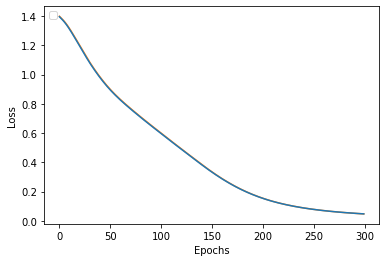

In [317]:
# Plot Loss vs Epochs
plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(range(len(list_train_loss)),list_train_loss,'tab:orange',label='Training Loss')
plt.plot(range(len(list_val_loss)), list_val_loss,'tab:blue',label='Validation Loss')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


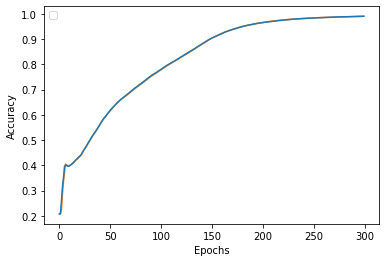

In [318]:
# Plot Accuracy vs Epochs
plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(range(len(list_train_acc)),list_train_acc,'tab:orange',label='Training Accuracy')
plt.plot(range(len(list_val_acc)),list_val_acc,'tab:blue',label='Validation Accuracy')

In [45]:
# Returns Cohort Name and Animal ID
def get_video_details(file_name):
    # Get cohort name
    cohort_name = file_name.split("FC-")[-1][0].lower()
    animal_id = file_name.split("cam_")[-1].split("-")[0]
    return cohort_name, animal_id

In [46]:
frame_data_set = set(frame_data_list)
final_training_set = set(final_training_list)

In [47]:
#New Random Seed
random.seed(1234)
testing_sample_number = 1200000
test_list = random.sample(list(frame_data_set - final_training_set), testing_sample_number)

In [51]:
test_latent_array = []
test_label_array = []

In [49]:
preexposure = 0
postcond = 0
postext = 0
postret = 0

for sample in test_list:
    if "preexposure" in sample:
        preexposure += 1
    elif "postcond" in sample:
        postcond += 1
    elif "postext" in sample:
        postext += 1
    elif "postret" in sample:
        postret += 1

print("PCA Training Samples split:\nPreexposure:", preexposure, "\nPostcond:", postcond, "\nPostext:", postext, "\nPostret:", postret)

PCA Training Samples split:
Preexposure: 405761 
Postcond: 227063 
Postext: 189788 
Postret: 377388


In [ ]:
image_count = 0

for image in test_list[len(test_label_array):]:
    image_count += 1
    if image_count % 10000 == 0:
        print("Processed", image_count, "Images..")
    name = image
    image = cv2.imread(image)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
    tensor_frame = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).cuda()
    with torch.no_grad():
        latent_representation = ae_model_weighted.module.encoder(tensor_frame)
    test_latent_array.append(latent_representation.squeeze().cpu().numpy())
    
    # Append One Hot encoded Labels
    if "preexposure" in name:
        test_label_array.append([1.0, 0.0, 0.0, 0.0])
    elif "postcond" in name:
        test_label_array.append([0.0, 1.0, 0.0, 0.0])
    elif "postext" in name:
        test_label_array.append([0.0, 0.0, 1.0, 0.0])
    elif "postret" in name:
        test_label_array.append([0.0, 0.0, 0.0, 1.0])
    else:
        print("ERROR: Incorrect Experiment Phase, no label associated.")
        

Processed 10000 Images..


In [294]:
len(test_label_array)

1200000

In [319]:
# Save Test Latents
# np.save("shuffledTestLatents1_2mil_ae_weighted.npy", test_latent_array)
# np.save("shuffledTestLabels1_2mil_ae_weighted.npy", test_label_array)

# Load Test Latents
test_latent_array = np.load("shuffledTestLatents1_2mil.npy")
test_label_array = np.load("shuffledTestLabels1_2mil.npy")

In [493]:
test_latent_array = np.load("shuffledTestLatents1_2mil.npy")
test_label_array = np.load("shuffledTestLabels1_2mil.npy")

In [495]:
print("Length before appending:", len(test_label_array))
pre_testing_labels = [[1.0, 0.0, 0.0, 0.0] for i in range(len(testing_latents))]
test_label_array2 = np.concatenate((test_label_array, pre_testing_labels))
test_latent_array2 = np.concatenate((test_latent_array, testing_latents))
print("Length after appending:", len(test_label_array2))

Length before appending: 1200000
Length after appending: 1361675


In [496]:
# Testing Dataset
batch_size = 512
# test_data = list(zip(test_latent_array, test_label_array))

# test_data = list(zip(testing_latents, pre_testing_labels))
test_data = list(zip(test_latent_array2, test_label_array2))
test_dataset = LatentDataset(test_data)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers = 4, shuffle=True)

In [497]:
# Loading pre-trained Model
# model.load_state_dict(torch.load("LinearClassifierFinal/latent_classifier_e1995_v0.9997875.p"))

In [498]:
def test(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    
    predictions = []
    targets = []

    model.eval()
    with torch.no_grad():
        for sample in tqdm(iterator, desc="Validating", leave=False):
            latent, label = sample
        
            latent = latent.to(device)
            label = label.squeeze().to(device)
            
            y_pred = model(latent)

            loss = criterion(y_pred, label)
            acc = calculate_accuracy(y_pred, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            targets.append(label)
            predictions.append(y_pred)

    return epoch_loss / len(iterator), epoch_acc / len(iterator), predictions, targets

In [499]:
# old_model = model
new_model = model
new_model.load_state_dict(torch.load("LinearClassifierFinal/control_animals_expt_mse_e295_v0.9895146048379565.p"))
new_model.eval()

MLP(
  (input_fc): Linear(in_features=32, out_features=128, bias=True)
  (hidden_fc1): Linear(in_features=128, out_features=64, bias=True)
  (hidden_fc2): Linear(in_features=64, out_features=32, bias=True)
  (output_fc): Linear(in_features=32, out_features=4, bias=True)
)

In [500]:
# Testing the model
start_time = time.monotonic()
test_loss, test_acc, predictions, targets = test(new_model, test_loader, criterion, device)

end_time = time.monotonic()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)

# list_test_loss.append(test_loss)
# list_test_acc.append(test_acc)
        
print('Finished Testing in', end_time-start_time, "seconds")

Finished Testing in 9.632754767022561 seconds


In [501]:
print("Test Loss:", test_loss, " Test Acc:", test_acc)

Test Loss: 13.270867398628823  Test Acc: 0.2799679671239136


In [449]:
test_predictions = []
test_targets = []

for prediction_batch in predictions:
    for prediction in prediction_batch:
        test_predictions.append(torch.argmax(prediction, dim = 0).cpu().numpy())
        
for target_batch in targets:
    for target in target_batch:
        test_targets.append(torch.argmax(target, dim = 0).cpu().numpy())

In [450]:
# Array of (Batch, Index) of incorrect predictions
# misclassified_indices = []

# for batch in range(len(predictions)):
#     for index in range(len(predictions[batch])):
#         if torch.argmax(predictions[batch][index], dim = 0).cpu().numpy() != torch.argmax(targets[batch][index], dim = 0).cpu().numpy():
#             misclassified_indices.append((batch, index))
# misclassified_indices[0:10]

In [451]:
# for index in misclassified_indices:
#     print((index[0], index[1]), "-> Prediction:" , torch.argmax(predictions[index[0]][index[1]], dim = 0).cpu().numpy(), "Label:", torch.argmax(targets[index[0]][index[1]], dim = 0).cpu().numpy())

In [452]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(test_targets, test_predictions)

print(cf_matrix)

[[117663   1072   8614  34326]
 [     0      0      0      0]
 [     0      0      0      0]
 [     0      0      0      0]]


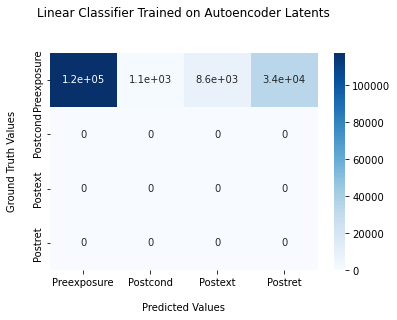

In [453]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Linear Classifier Trained on Autoencoder Latents\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Ground Truth Values\n');

ax.xaxis.set_ticklabels(['Preexposure', 'Postcond', 'Postext', 'Postret'])
ax.yaxis.set_ticklabels(['Preexposure', 'Postcond', 'Postext', 'Postret'])

plt.show()

In [65]:
# TODO List:
# Get mapping of Test and Training Sets -> DONE
# Create disjoint train and test list -> Frame Level -> DONE
# Create disjoint train and test list -> Animal Level (:IMPORTANT: Acc should be low.) 
# Create disjoint train and test list -> Co-hort Level
# Control Animals on U-MAP and Linear Classifier -> DONE
# GradCAM -> Gradient across both encoder and classifier ->DONE

In [454]:
class FusedModelDataset(torch.utils.data.Dataset):
    def __init__(self, frame_list, augmentations = None):
        super(FusedModelDataset, self).__init__()
        self.frame_list = frame_list
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.frame_list)

    def __getitem__(self, idx):
        # Load Image using PIL
        img = Image.open(self.frame_list[idx])
        # Resize to 224x224
        img = torchvision.transforms.Resize((224, 224))(img)
        # Need to convert to a Tensor, Resize doesn't return a Tensor
        img = torchvision.transforms.ToTensor()(img)
        label = torch.tensor(get_experiment_phase_from_name(self.frame_list[idx]))
        return img, label

In [461]:
control_list = list(control_set)

In [462]:
batch_size = 512
fused_model_test_list = control_list[:1024]
fused_model_testing = FusedModelDataset(fused_model_test_list)
fused_model_test_loader = torch.utils.data.DataLoader(fused_model_testing, batch_size=batch_size, num_workers = 4, shuffle=True)

In [463]:
class MLP2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 128)
        self.hidden_fc1 = nn.Linear(128, 64)
        self.hidden_fc2 = nn.Linear(64, 32)
        self.output_fc = nn.Linear(32, output_dim)

    def forward(self, x):
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc1(h_1))
        h_3 = F.relu(self.hidden_fc2(h_2))
        y_out = self.output_fc(h_3)
        y_pred = torch.sigmoid(y_out)

        return y_out

In [464]:
class FusedEncodingModel(nn.Module):
    def __init__(self, autoencoder_model, mlp_model2, autoencoder_model_weights_path, mlp_model_weights_path):
        super().__init__()
        
       
            
        INPUT_DIM = 32
        OUTPUT_DIM = 4

#         mlp_model2 = MLP2(INPUT_DIM, OUTPUT_DIM)

        self.autoencoder_model = autoencoder_model
        self.autoencoder_model.load_state_dict(torch.load(autoencoder_model_weights_path))
        
        self.encoder = self.autoencoder_model.module.encoder
        
        self.mlp_model = mlp_model2
#         self.mlp_model.load_state_dict(torch.load(mlp_model_weights_path))

    def forward(self, x):
        latent_representation = self.encoder(x)
        class_prediction = self.mlp_model(latent_representation)
        
        return class_prediction

In [465]:
fused_model = FusedEncodingModel(ae_model_weighted, model, "new_architecture_MSE_e2400.p", "control_animals_expt_mse_e295_v0.9895146048379565.p")
fused_model = fused_model.to(device)
fused_model.eval()

FusedEncodingModel(
  (autoencoder_model): DataParallel(
    (module): newAE(
      (encoder): ResNet18Enc(
        (ResNet18): ResNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): BasicBlock(
              (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (1): B

### GradCam

In [466]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

torch.Size([1, 3, 224, 224])

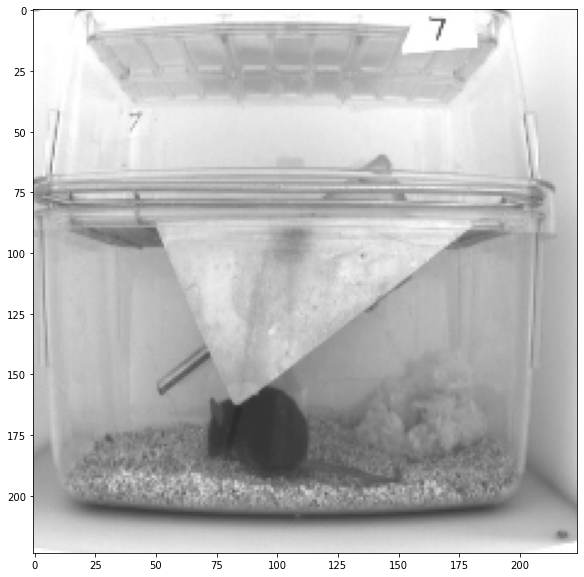

In [492]:
target_layers = [fused_model.encoder.ResNet18.layer3[-1]]
test_image = control_list[1007]
test_image = cv2.imread(test_image)
test_image = cv2.resize(test_image, (224, 224))
plt.figure(figsize=(10,10))
plt.imshow(test_image)
input_tensor = torchvision.transforms.functional.to_tensor(test_image/255.).unsqueeze(0).float()
input_tensor.shape

In [470]:
cam = GradCAM(model=fused_model, target_layers=target_layers, use_cuda=True)

In [471]:
def show_gradcam_for_image(file_name):
    test_image = cv2.imread(file_name)
    test_image = cv2.resize(test_image, (224, 224))
    input_tensor = torchvision.transforms.functional.to_tensor(test_image/255.).unsqueeze(0).float()
    
    grayscale_cam = cam(input_tensor=input_tensor)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(test_image/255., grayscale_cam, use_rgb=True)
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(visualization)

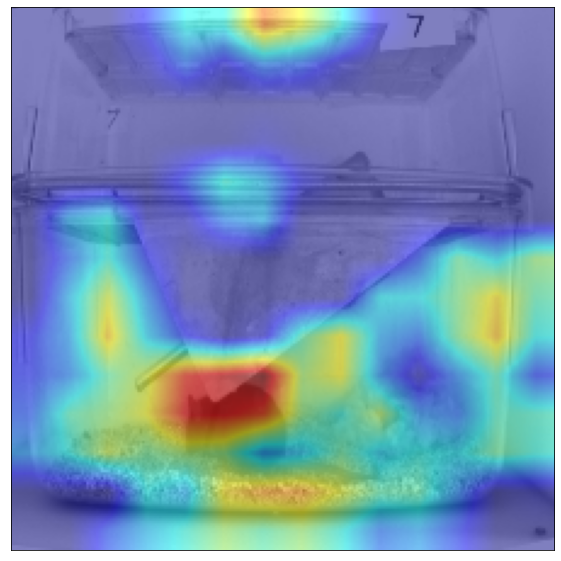

In [491]:
show_gradcam_for_image(control_list[1007])